## Supermarket store branches sales analysis
https://www.kaggle.com/datasets/surajjha101/stores-area-and-sales-data

At the end of this project, I'll try to predict the Store Sales of Supermarket Store Branches

In [24]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
df = pd.read_csv('Stores.csv')

In [4]:
df.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1,1659,1961,530,66490
1,2,1461,1752,210,39820
2,3,1340,1609,720,54010
3,4,1451,1748,620,53730
4,5,1770,2111,450,46620


In [5]:
# There're only numeric variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Store ID              896 non-null    int64
 1   Store_Area            896 non-null    int64
 2   Items_Available       896 non-null    int64
 3   Daily_Customer_Count  896 non-null    int64
 4   Store_Sales           896 non-null    int64
dtypes: int64(5)
memory usage: 35.1 KB


In [6]:
# There is no NaN
df.isna().sum()

Store ID                0
Store_Area              0
Items_Available         0
Daily_Customer_Count    0
Store_Sales             0
dtype: int64

In [7]:
df.describe()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
count,896.000000,896.000000,896.000000,896.000000,896.000000
mean,448.500000,1485.409598,1782.035714,786.350446,59351.305804
std,258.797218,250.237011,299.872053,265.389281,17190.741895
min,1.000000,775.000000,932.000000,10.000000,14920.000000
25%,224.750000,1316.750000,1575.500000,600.000000,46530.000000
50%,448.500000,1477.000000,1773.500000,780.000000,58605.000000
75%,672.250000,1653.500000,1982.750000,970.000000,71872.500000
max,896.000000,2229.000000,2667.000000,1560.000000,116320.000000


In [8]:
# There's one branch that only has 10 daily customers. This value seems is to be too low in comparison with the mean,
# so it might be an outlier
df.Daily_Customer_Count.nsmallest(5)

39      10
151     70
876    100
230    120
146    130
Name: Daily_Customer_Count, dtype: int64

In [32]:
# Getting the z-score of that value. 
# It'll be considered an outlier if the zscore is greater than |3|
scipy.stats.zscore(df.Daily_Customer_Count)[39]

-2.926960872097397

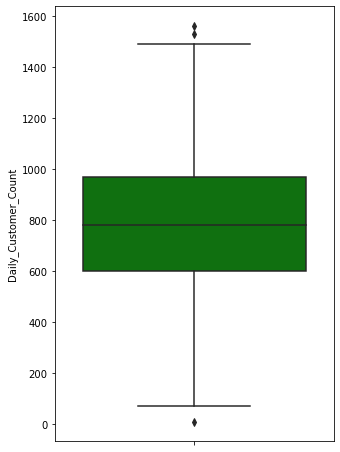

In [9]:
# Checking wheter the 10 daily consumers is really too low or an accetable value.
# It's not very far from the last percentile, so I'll keep it.
plt.figure(figsize=(5,8))
sns.boxplot(data = df , y = 'Daily_Customer_Count', color = 'green');

In [10]:
# Visualizing the other columns in the line where the daily costumer is 10 to check if they seem ok, only to confirm.
# All the other lines show regular values.
df.loc[39]


Store ID                   40
Store_Area               1270
Items_Available          1516
Daily_Customer_Count       10
Store_Sales             45480
Name: 39, dtype: int64

In [33]:
# There is no duplicated values.
df.duplicated().sum()

0

In [11]:
df.columns

Index(['Store ID ', 'Store_Area', 'Items_Available', 'Daily_Customer_Count',
       'Store_Sales'],
      dtype='object')

In [12]:
# Taking the black space out of the first column name ('Store ID').
df.columns = df.columns.str.replace(df.columns[0], df.columns[0][:-1])

In [13]:
df.columns

Index(['Store ID', 'Store_Area', 'Items_Available', 'Daily_Customer_Count',
       'Store_Sales'],
      dtype='object')

In [14]:
# Setting Store ID as index
df.set_index(['Store ID'])

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
Store ID,,,,
1,1659,1961,530,66490
2,1461,1752,210,39820
3,1340,1609,720,54010
4,1451,1748,620,53730
5,1770,2111,450,46620
...,...,...,...,...
892,1582,1910,1080,66390
893,1387,1663,850,82080
894,1200,1436,1060,76440


# Variable Analysis:
- Comparar as variáveis com a variável target 'Store_Sales'

- Comparar a quantidade de itens avaliable com base na área da loja
- comparar o numero de clientes com base na area da loja
- comparar o numero de clientes com base na quantidade de clientes

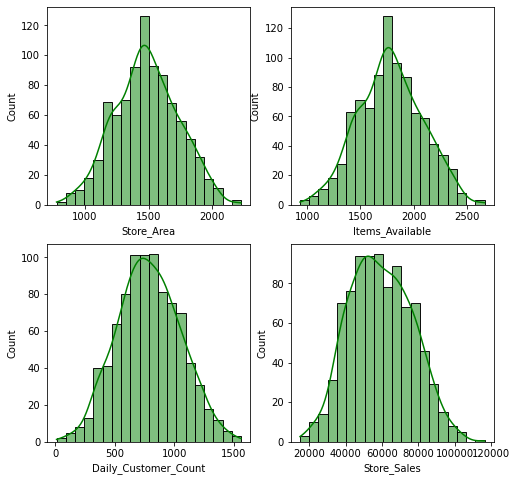

In [15]:
# Plotting a histogram to all the variables of the dataset
# They alll have a normal distribution
plt.figure(figsize = (8,8))

for i in range(1, len(df.columns)):
    plt.subplot(2, 2, i)
    sns.histplot(data = df, x = df.columns[i], bins = 20, color = 'green', kde = True)

In [16]:
# Variables Correlation
corr_df = df[df.columns].corr()

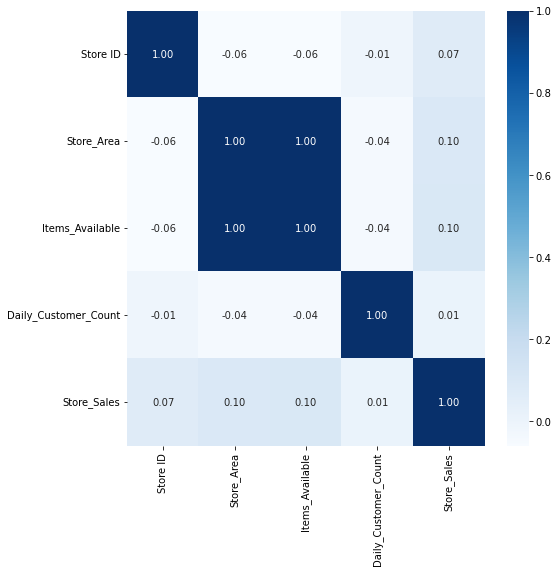

In [17]:
# Heatmap
# It's possible to see that Store_Area and Item_avaliable is totally positive related(1.0). 
# Even tough it's suspicious to have such a positive relation, it makes sense, since the more itens a supermarket has,
# the more area is needed
# The others variables are not much related.
plt.figure(figsize=(8,8))

sns.heatmap(data = corr_df, cmap = 'Blues', annot = True, fmt = '.2f')

*Decision*: We might take a decision here to only apply Feature Engineering in variables which the correlation is >=  0.10

In [18]:
df.columns

Index(['Store ID', 'Store_Area', 'Items_Available', 'Daily_Customer_Count',
       'Store_Sales'],
      dtype='object')

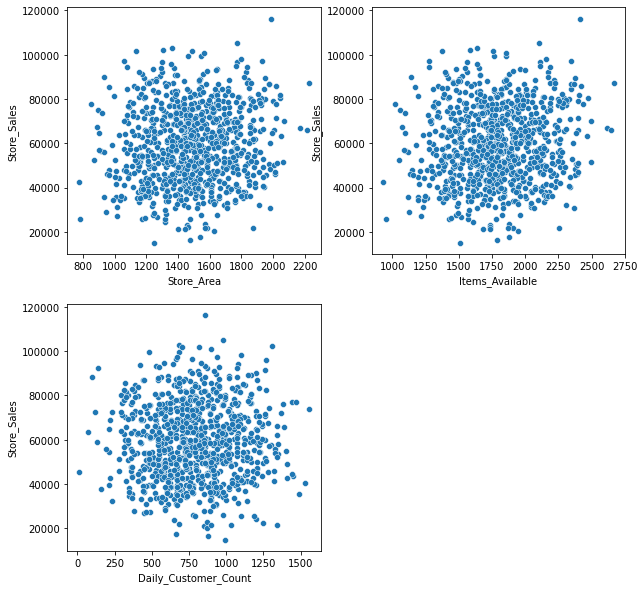

In [19]:
# Comparing the variables with the the Store Sales using a scatterplot
plt.figure(figsize=(10,10))

for i in range(1, len(df.columns)-1):
    plt.subplot(2,2, i)
    sns.scatterplot(data = df, x = df.columns[i], y = 'Store_Sales');

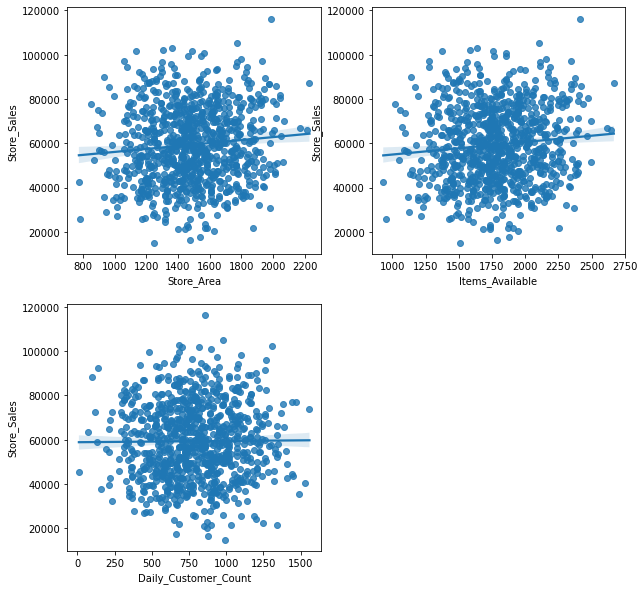

In [20]:
# In this graph (regression plot) it's possible to see more clearly that the relation between the variables and the Store Sales
# are too weak.
# It's not possible to say clearly that the grater the Store Area, Items Avaliable, and Daily Customer, the greater are 
# Store Sales too.
plt.figure(figsize=(10,10))

for i in range(1,len(df.columns)-1):
    plt.subplot(2,2,i)
    sns.regplot(data = df, x = df.columns[i], y='Store_Sales')

0